In [1]:
import sys
sys.path[0]="/Users/kwaneu/research/velocity/"
#print(sys.path)
import pandas as pd
import numpy as np
import velocity
from velocity.chemistry import Species, Reaction, Network
from math import sqrt
import lmfit
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
# parameter bounds
min_log10_base_rate_constant = -4
max_log10_base_rate_constant = -1
min_log10_selectivity = -1
max_log10_selectivity = 1
min_log10_catalyst_deactivation_rate_constant = -6
default_log10_catalyst_deactivation_rate_constant = np.log10(0.000014)
max_log10_catalyst_deactivation_rate_constant = -4

In [3]:
# setup sugars
glucose = Species("Glc", "glucose")
mannose = Species("Man", "mannose")
altrose = Species("Alt", "altrose")
allose = Species("All", "allose")
gulose = Species("Gul", "gulose")
galactose = Species("Gal", "galactose")
talose = Species("Tal", "talose")
idose = Species("Ido", "idose")

# must match order in spreadsheet!
sugars = [ glucose, mannose, allose, galactose, altrose, talose, gulose, idose ]
sugars_dict = { s.abbreviation : s for s in sugars }
sugar_abbreviations = [ s.abbreviation for s in sugars ]

# setup catalyst
catalyst_active = Species("cat", "catalyst (active)")
catalyst_dead = Species("dead", "catalyst (dead)")

# these are the network connections
CONNECTIONS = ["Glc_All",  "Glc_Gal",  "Glc_Man",
               "All_Gul",  "Gul_Gal",  "Gal_Tal",
               "Tal_Man",  "Man_Alt",  "Alt_All",
               "Alt_Ido",  "Tal_Ido",  "Ido_Gul"]

In [4]:
def add_connection(reactions_dict, connection_string, base_rate_constant, selectivity):
    sugar1, sugar2 = connection_string.split("_")
    sugar1 = sugars_dict[sugar1]
    sugar2 = sugars_dict[sugar2]

    jk1 = base_rate_constant*sqrt(selectivity)
    jk2 = base_rate_constant/sqrt(selectivity)
    reaction = Reaction({sugar1:1, catalyst_active:1}, {sugar2:1, catalyst_active:1}, reversible=True)
    reactions_dict[reaction] = (jk1,jk2)

In [27]:
def create_network(x):
    reactions_dict = {}

    for connection in CONNECTIONS:
        base_rate_constant = np.power(10, x[f"{connection}_log10_base_rate_constant"])
        selectivity = np.power(10, x[f"{connection}_log10_selectivity"])
        add_connection(reactions_dict, connection, base_rate_constant, selectivity)

    catalyst_deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
    #reactions_dict[catalyst_deactivation_reaction] = np.power(10.0,x["log10_catalyst_deactivation_rate_constant"])
    
    network = Network(reactions_dict, fixed_concentrations=None)
    return network

In [28]:
def add_parameters(connection, base_rate_constant, selectivity, vary=(False,False)):
    vary_rate, vary_selectivity = vary
    parameter = lmfit.Parameter(
        name = f"{connection}_log10_base_rate_constant",
        min = min_log10_base_rate_constant,
        value = np.log10(base_rate_constant*1e-6),
        max = max_log10_base_rate_constant,
        vary = True
    )
    parameters.add(parameter)

    parameter = lmfit.Parameter(
        name = f"{connection}_log10_selectivity",
        min = min_log10_selectivity,
        value = np.log10(convert(selectivity)),
        max = max_log10_selectivity,
        vary = False
    )
    parameters.add(parameter)

In [29]:
def convert(selectivity):
    """Converts negative selectivites into inverse selectivities.

    Leaves positive selectivities untouched.

    Args:
        selectivity (int or float): The selectivity to convert.

    Returns:
        selectivity (float): The converted selectivity.
    """
    selectivity = float(selectivity)
    if selectivity < 0.0:
        selectivity = -1.0/selectivity
    return selectivity

In [30]:
# generate times to run simulation over
t_span = (0.0, 1e6)
t_eval = np.linspace(0.0, 1e6, 1001)
t_eval

array([      0.,    1000.,    2000., ...,  998000.,  999000., 1000000.])

In [31]:
parameters = lmfit.Parameters()

add_parameters("Glc_All", 11413,  10)
add_parameters("Glc_Gal",  2788,   1)
add_parameters("Glc_Man",  1745,  -3)
add_parameters("All_Gul",  3408, -10)
add_parameters("Gul_Gal",  5165,   1)
add_parameters("Gal_Tal",  2556,  10)
add_parameters("Tal_Man",  4366, -10)
add_parameters("Man_Alt",  7893,  -2)
add_parameters("Alt_All",  2632,  10)
add_parameters("Alt_Ido",  4593,   1)
add_parameters("Tal_Ido",  4783, -10)
add_parameters("Ido_Gul",  2087,   2)

parameter = lmfit.Parameter(
    name = f"log10_catalyst_deactivation_rate_constant",
    min = min_log10_catalyst_deactivation_rate_constant,
    value = default_log10_catalyst_deactivation_rate_constant,
    max = max_log10_catalyst_deactivation_rate_constant,
    vary = False
)
parameters.add(parameter)
#parameters.pretty_print()
#print(f"There are {len(parameters)} parameters.\n")

In [32]:
network = create_network(parameters)

initial_concentrations_dict = {
    allose : 0.2,
    catalyst_active : 0.2*0.02,
}
concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)
concentrations_df = concentrations_df*100.0/0.2

In [33]:
concentrations_df

,All,Alt,cat,Gal,Glc,Gul,Ido,Man,Tal
time,,,,,,,,,
0.0,100.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1000.0,97.927977,0.314101,2.0,0.011622,1.320211,0.412066,0.004044,0.009572,0.000407
2000.0,96.099696,0.593742,2.0,0.043395,2.420560,0.788854,0.015159,0.035594,0.003000
3000.0,94.479678,0.843125,2.0,0.091362,3.335711,1.134029,0.032033,0.074631,0.009431
4000.0,93.036624,1.066004,2.0,0.152064,4.096138,1.450889,0.053516,0.123696,0.021070
...,...,...,...,...,...,...,...,...,...
996000.0,40.410422,2.944847,2.0,3.963816,4.230014,4.241217,3.337190,3.932841,36.939653
997000.0,40.410008,2.944852,2.0,3.963811,4.230090,4.241208,3.337208,3.932850,36.939972
998000.0,40.409635,2.944853,2.0,3.963811,4.230126,4.241197,3.337227,3.932863,36.940287


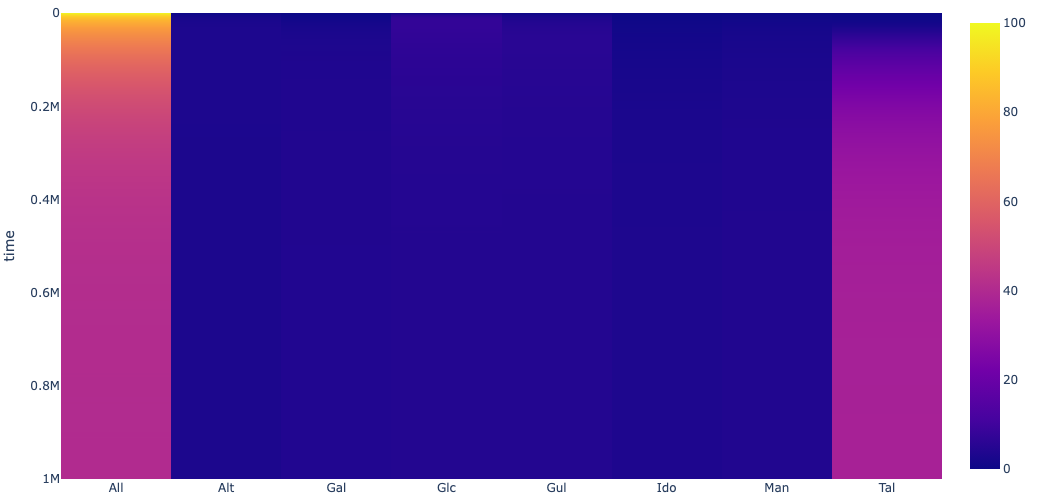

In [34]:
temp_df = concentrations_df.iloc[:,:]
temp_df = temp_df[["All","Alt","Gal","Glc","Gul","Ido","Man","Tal"]]
fig = px.imshow(temp_df)
fig.update_layout(
    margin = dict(t=5,r=5,b=5,l=5),
    showlegend = False,
    height = 500,
    width = 500,
    autosize = False )
fig.show()

In [102]:
temp_df = concentrations_df.iloc[[0,22],:].copy()
temp_df = temp_df[["All","Alt","Gal","Glc","Gul","Ido","Man","Tal"]]
temp_df = temp_df.round(1)
temp_df

,All,Alt,Gal,Glc,Gul,Ido,Man,Tal
time,,,,,,,,
0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
22000.0,74.2,2.4,3.8,9.5,4.1,0.6,1.6,3.8


In [48]:
temp_df = concentrations_df.iloc[[0,22,-1],:].copy()
temp_df = temp_df[["All","Alt","Gal","Glc","Gul","Ido","Man","Tal"]]
temp_df = temp_df.round(1)
temp_df

,All,Alt,Gal,Glc,Gul,Ido,Man,Tal
time,,,,,,,,
0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
22000.0,74.2,2.4,3.8,9.5,4.1,0.6,1.6,3.8
1000000.0,40.4,2.9,4.0,4.2,4.2,3.3,3.9,36.9


In [90]:
temp_df.tail(1)

,All,Alt,Gal,Glc,Gul,Ido,Man,Tal
time,,,,,,,,
1000000.0,40.4,2.9,4.0,4.2,4.2,3.3,3.9,36.9


In [115]:
R = 3.1668105e-6 * 627.509 # kcal/K
temperature = 298.15

In [129]:
fractions = []
count = 0
scale = 2.0
for i in range(100000):    
    energies = np.random.normal(loc=0.0, scale=scale, size=8)
    energies = np.sort(energies)

    weights = np.exp(-1*energies/(R*temperature))
    weights = weights / np.sum(weights)
    fractions.append(weights[0])
    if weights[0] > 0.9:
        count += 1

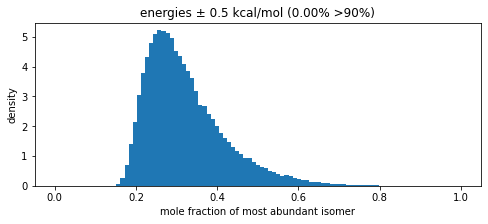

In [125]:
plt.figure(figsize=(8,3))
plt.hist(fractions,bins=np.linspace(0.0,1.0,100), density=True)
plt.title(f"energies ± {scale:.1f} kcal/mol ({count/1000:.2f}% >90%)")
plt.ylabel("density")
plt.xlabel("mole fraction of most abundant isomer")
plt.show()

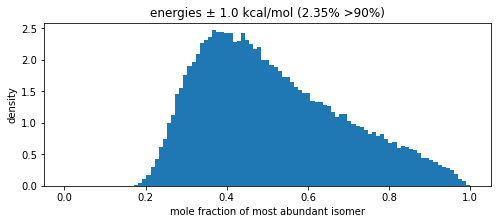

In [127]:
plt.figure(figsize=(8,3))
plt.hist(fractions,bins=np.linspace(0.0,1.0,100), density=True)
plt.title(f"energies ± {scale:.1f} kcal/mol ({count/1000:.2f}% >90%)")
plt.ylabel("density")
plt.xlabel("mole fraction of most abundant isomer")
plt.show()

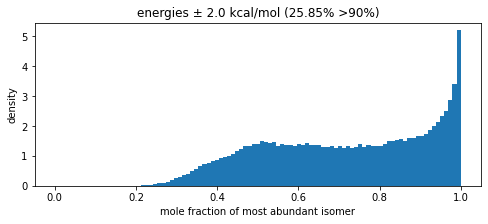

In [130]:
plt.figure(figsize=(8,3))
plt.hist(fractions,bins=np.linspace(0.0,1.0,100), density=True)
plt.title(f"energies ± {scale:.1f} kcal/mol ({count/1000:.2f}% >90%)")
plt.ylabel("density")
plt.xlabel("mole fraction of most abundant isomer")
plt.show()

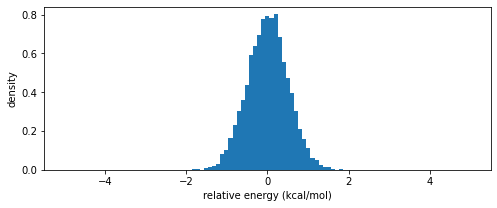

In [111]:
energies = np.random.normal(loc=0.0, scale=0.5, size=10000)
plt.figure(figsize=(8,3))
plt.hist(energies, bins=np.linspace(-5.0,5.0,100), density=True)
plt.xlabel("relative energy (kcal/mol)")
plt.ylabel("density")
plt.show()

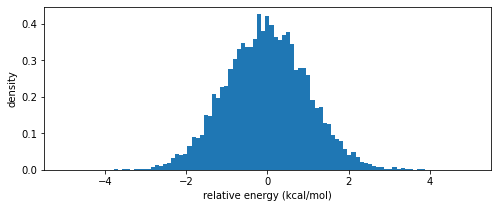

In [112]:
energies = np.random.normal(loc=0.0, scale=1.0, size=10000)
plt.figure(figsize=(8,3))
plt.hist(energies, bins=np.linspace(-5.0,5.0,100), density=True)
plt.xlabel("relative energy (kcal/mol)")
plt.ylabel("density")
plt.show()

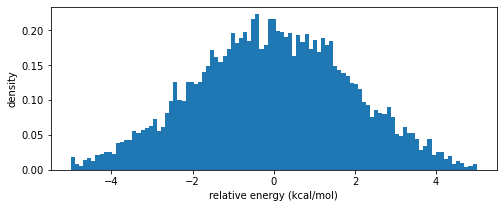

In [110]:
energies = np.random.normal(loc=0.0, scale=2.0, size=10000)
plt.figure(figsize=(8,3))
plt.hist(energies, bins=np.linspace(-5.0,5.0,100), density=True)
plt.xlabel("relative energy (kcal/mol)")
plt.ylabel("density")
plt.show()